## Start ai-docstring server
Running flask app server in Google Colab for people without GPU

#### Clone github repository

In [1]:
!git clone https://github.com/graykode/ai-docstring.git
%cd ai-docstring
!pip install -r server/requirements.txt

Cloning into 'ai-docstring'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 893 (delta 145), reused 172 (delta 86), pack-reused 627
Receiving objects: 100% (893/893), 2.39 MiB | 28.79 MiB/s, done.
Resolving deltas: 100% (529/529), done.
/content/ai-docstring
     |████████████████████████████████| 1.1MB 8.1MB/s 
     |████████████████████████████████| 1.3MB 25.1MB/s 
     |████████████████████████████████| 890kB 39.9MB/s 
     |████████████████████████████████| 2.9MB 51.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=576bde7e9db91b630dc0bf31f4216e46f5605711b2503875927f558d9a7756ea
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


#### Download model weights

Download the two weights of model from the google drive through the gdown module. [Added model](https://drive.google.com/uc?id=1YrkwfM-0VBCJaa9NYaXUQPODdGPsmQY4) : A model trained Code2NL on Python using pre-trained CodeBERT (Feng at al, 2020).

In [2]:
!pip install gdown \
  && gdown "https://drive.google.com/uc?id=1YrkwfM-0VBCJaa9NYaXUQPODdGPsmQY4" \
  -O server/pytorch_model.bin

Downloading...
From: https://drive.google.com/uc?id=1YrkwfM-0VBCJaa9NYaXUQPODdGPsmQY4
To: /content/ai-docstring/server/pytorch_model.bin
707MB [00:02, 242MB/s]


#### ngrok setting with flask

Before starting the server, you need to configure ngrok to open this notebook to the outside. I have referred [this jupyter notebook](https://github.com/alievk/avatarify/blob/master/avatarify.ipynb) in detail.

In [3]:
!pip install flask-ngrok

Go to https://dashboard.ngrok.com/auth/your-authtoken (sign up if required), copy your authtoken and put it below.



In [4]:
# Paste your authtoken here in quotes
authtoken = "1kYudX4tR8jXABUYgInnAC5kKPV_3u1GacmwUXFtPAacQ4Vcu"

Set your region

Code | Region
--- | ---
us | United States
eu | Europe
ap | Asia/Pacific
au | Australia
sa | South America
jp | Japan
in | India

In [5]:
# Set your region here in quotes
region = "jp"

# Input and output ports for communication
local_in_port = 5000
local_out_port = 5000

In [6]:
config =\
f"""
authtoken: {authtoken}
region: {region}
console_ui: False
tunnels:
  input:
    addr: {local_in_port}
    proto: http    
  output:
    addr: {local_out_port}
    proto: http
"""

with open('ngrok.conf', 'w') as f:
  f.write(config)

In [7]:
import time
from subprocess import Popen, PIPE

# (Re)Open tunnel
ps = Popen('./scripts/open_tunnel_ngrok.sh', stdout=PIPE, stderr=PIPE)
time.sleep(3)

#### Run you server!

In [8]:
%cd server

/content/ai-docstring/server


In [9]:
import os
import json
import time
import torch
import argparse
import torch.nn as nn
from model import Seq2Seq
from flask import Flask, jsonify, request
from utils import Example, convert_examples_to_features, logger
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

In [10]:
def inference(data):
    # Calculate bleu
    eval_sampler = SequentialSampler(data)
    eval_dataloader = DataLoader(data, sampler=eval_sampler, batch_size=len(data))

    args.model.eval()
    p = []
    for batch in eval_dataloader:
        batch = tuple(t.to(args.device) for t in batch)
        source_ids, source_mask = batch
        with torch.no_grad():
            preds = args.model(source_ids=source_ids, source_mask=source_mask)
            for pred in preds:
                t = pred[0].cpu().numpy()
                t = list(t)
                if 0 in t:
                    t = t[: t.index(0)]
                text = args.tokenizer.decode(t, clean_up_tokenization_spaces=False)
                p.append(text)
    return (p, source_ids.shape[-1])


def get_features(examples):
    features = convert_examples_to_features(
        examples, args.tokenizer, args, stage="test"
    )
    all_source_ids = torch.tensor(
        [f.source_ids[: args.max_source_length] for f in features], dtype=torch.long
    )
    all_source_mask = torch.tensor(
        [f.source_mask[: args.max_source_length] for f in features], dtype=torch.long
    )
    return TensorDataset(all_source_ids, all_source_mask)


def build_model(model_class, config, tokenizer):
    encoder = model_class(config=config)
    decoder_layer = nn.TransformerDecoderLayer(
        d_model=config.hidden_size, nhead=config.num_attention_heads
    )
    decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
    model = Seq2Seq(
        encoder=encoder,
        decoder=decoder,
        config=config,
        beam_size=args.beam_size,
        max_length=args.max_target_length,
        sos_id=tokenizer.cls_token_id,
        eos_id=tokenizer.sep_token_id,
    )

    assert os.path.exists("pytorch_model.bin"), "Weight is not downloaded."

    model.load_state_dict(
        torch.load(
            "pytorch_model.bin",
            map_location=torch.device("cpu"),
        ),
        strict=False,
    )
    return model


def create_app():
    @app.route("/")
    def index():
        return jsonify(hello="world")

    @app.route("/summary", methods=["POST"])
    def summary():
        if request.method == "POST":
            payload = request.get_json()
            example = [
                Example(
                    source=payload["code"],
                    target=None,
                )
            ]

            t0 = time.time()
            message, length = inference(data=get_features(example))
            t1 = time.time()
            result = {
                'message' : message,
                'time' : (t1 - t0),
                'device' : args.device_name,
                'length' : length
            }
            logger.info(json.dumps(result, indent=4))
            return jsonify(**result)

    @app.route("/tokenizer", methods=["POST"])
    def tokenizer():
        if request.method == "POST":
            payload = request.get_json()
            tokens = args.tokenizer.tokenize(payload["code"])
            return jsonify(tokens=tokens)

    return app

**Set enviroment**

In [11]:
import easydict 

args = easydict.EasyDict({
    'max_source_length': 512, 
    'max_target_length': 128,
    'beam_size': 10,
    'device' : torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'device_name' : "cuda" if torch.cuda.is_available() else "cpu"
})

In [ ]:
# flask_ngrok_example.py
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

config = RobertaConfig.from_pretrained("microsoft/codebert-base")
args.tokenizer = RobertaTokenizer.from_pretrained(
    "microsoft/codebert-base", do_lower_case=False
)

args.model = build_model(
    model_class=RobertaModel, config=config, tokenizer=args.tokenizer
).to(args.device)

app = create_app()
app.run()

11/20/2020 16:46:55 - INFO - filelock -   Lock 139986594232024 acquired on /root/.cache/torch/transformers/1b62771d5f5169b34713b0af1ab85d80e11f7b1812fbf3ee7d03a866c5f58e72.06eb31f0a63f4e8a136733ccac422f0abf9ffa87c3e61104b57e7075a704d008.lock


11/20/2020 16:46:55 - INFO - filelock -   Lock 139986594232024 released on /root/.cache/torch/transformers/1b62771d5f5169b34713b0af1ab85d80e11f7b1812fbf3ee7d03a866c5f58e72.06eb31f0a63f4e8a136733ccac422f0abf9ffa87c3e61104b57e7075a704d008.lock


11/20/2020 16:46:56 - INFO - filelock -   Lock 139986594234096 acquired on /root/.cache/torch/transformers/aca4dbdf4f074d4e071c2664901fec33c8aa69c35aa0101bc669ed4b44d1f6c3.6a4061e8fc00057d21d80413635a86fdcf55b6e7594ad9e25257d2f99a02f4be.lock


11/20/2020 16:46:56 - INFO - filelock -   Lock 139986594234096 released on /root/.cache/torch/transformers/aca4dbdf4f074d4e071c2664901fec33c8aa69c35aa0101bc669ed4b44d1f6c3.6a4061e8fc00057d21d80413635a86fdcf55b6e7594ad9e25257d2f99a02f4be.lock


11/20/2020 16:46:57 - INFO - filelock -   Lock 139986594231016 acquired on /root/.cache/torch/transformers/779a2f0c38ba2ff65d9a3ee23e58db9568f44a20865c412365e3dc540f01743f.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock


11/20/2020 16:46:57 - INFO - filelock -   Lock 139986594231016 released on /root/.cache/torch/transformers/779a2f0c38ba2ff65d9a3ee23e58db9568f44a20865c412365e3dc540f01743f.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock


11/20/2020 16:46:58 - INFO - filelock -   Lock 139986594233648 acquired on /root/.cache/torch/transformers/5a191080da4f00859b5d3d29529f57894583e00ab07b7c940d65c33db4b25d4d.16f949018cf247a2ea7465a74ca9a292212875e5fd72f969e0807011e7f192e4.lock


11/20/2020 16:46:58 - INFO - filelock -   Lock 139986594233648 released on /root/.cache/torch/transformers/5a191080da4f00859b5d3d29529f57894583e00ab07b7c940d65c33db4b25d4d.16f949018cf247a2ea7465a74ca9a292212875e5fd72f969e0807011e7f192e4.lock


11/20/2020 16:46:59 - INFO - filelock -   Lock 139986594233648 acquired on /root/.cache/torch/transformers/1b4723c5fb2d933e11c399450ea233aaf33f093b5cbef3ec864624735380e490.70b5dbd5d3b9b4c9bfb3d1f6464291ff52f6a8d96358899aa3834e173b45092d.lock


11/20/2020 16:46:59 - INFO - filelock -   Lock 139986594233648 released on /root/.cache/torch/transformers/1b4723c5fb2d933e11c399450ea233aaf33f093b5cbef3ec864624735380e490.70b5dbd5d3b9b4c9bfb3d1f6464291ff52f6a8d96358899aa3834e173b45092d.lock



 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


11/20/2020 16:47:17 - INFO - werkzeug -    * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://a5a9029383b4.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


11/20/2020 16:49:15 - INFO - utils -   {
    "message": [
        "Convert a string of XML to a list of URLs ."
    ],
    "time": 0.7706730365753174,
    "device": "cuda",
    "length": 512
}
11/20/2020 16:49:15 - INFO - werkzeug -   127.0.0.1 - - [20/Nov/2020 16:49:15] "POST /summary HTTP/1.1" 200 -


## Set `ai-docstring` configure in vscode extension setting.
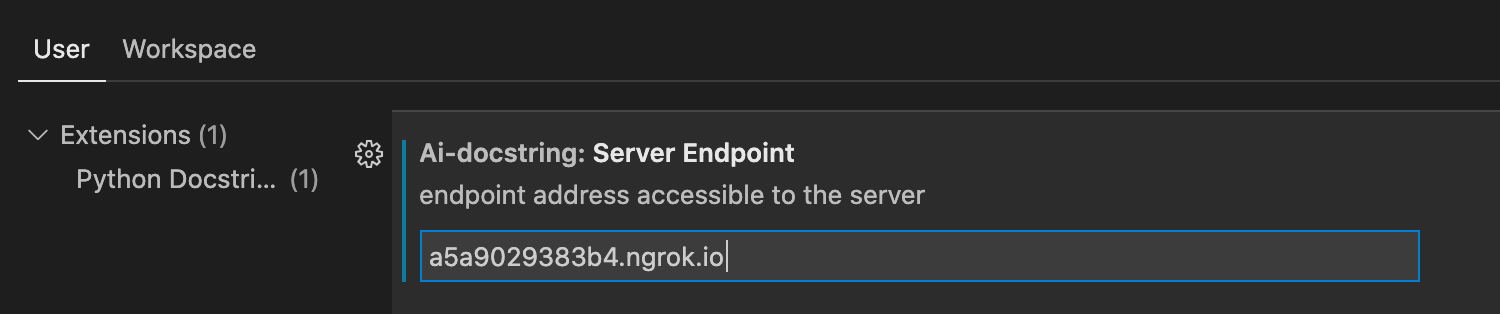
- `ai-docstring.ServerEndpoint`: endpoint address accessible to the server.